# Landsat and Sentinel comparison

**What does this notebook do?** This notebook allows comparison of Landsat and Sentinel data. Data from Landsat 8, Sentinel 2a and Sentinel 2b are pulled in for a study area. A plot is drawn up of a single time slice for once of the sensors so the user can select a pixel. Once a pixel is selected, a timeseries is plotted up for each sensor for that single pixel. Users can then select a point in the time series plot to generate a plot showing the satellite image at that point in time.

**Date** March 2018

**Author** Claire Krause

In [1]:
%pylab notebook
from datacube.storage import masking
from datacube import Datacube
from datetime import datetime
from skimage import exposure
import pandas as pd

# Import widgets for interactive notebook
from ipywidgets import interact, fixed
import ipywidgets as widgets

import sys
import os
sys.path.append(os.path.abspath('/g/data/r78/cek156/dea-notebooks/algorithms'))
import DEAPlotting
import DEADataHandling

Populating the interactive namespace from numpy and matplotlib


## Set up the extraction query

In [2]:
query = {'lat': (-29.982767, -30.000056),
         'lon': (146.880507, 146.908457),
         'output_crs': 'EPSG:3577',
         'resolution': (-10, 10),
        }

## First, pull in the data from Sentinel 2a, 2b and Landsat 8

In [3]:
# Replace '156' and 'cek156' with the path to your own home directory on the VDI
s2aws = Datacube(config='/home/156/cek156/Sentinel2_datacube.conf')
dc = Datacube(app = 'test')

#Sentineldata, S2crs, S2affine = DEADataHandling.load_sentinel(s2aws, 's2a_ard_granule', query)
#Landsatdata, LScrs, LSaffine = DEADataHandling.load_nbarx(dc, 'ls8', query, product = 'nbar')
Sentinel2anofilter = s2aws.load(product='s2a_ard_granule', group_by='solar_day', **query)
Sentinel2bnofilter = s2aws.load(product='s2b_ard_granule', group_by='solar_day', **query)
Landsatnofilter = dc.load(product = 'ls8_nbar_albers', group_by='solar_day', **query)

In [18]:
Sentinel2aNDWI = ((Sentinel2anofilter.green - Sentinel2anofilter.nir1)/
                  (Sentinel2anofilter.green + Sentinel2anofilter.nir1))
Sentinel2bNDWI = ((Sentinel2bnofilter.green - Sentinel2bnofilter.nir1)/
                  (Sentinel2bnofilter.green + Sentinel2bnofilter.nir1))
LandsatNDWI= ((Landsatnofilter.green - Landsatnofilter.nir)/
              (Landsatnofilter.green + Landsatnofilter.nir))

<IPython.core.display.Javascript object>


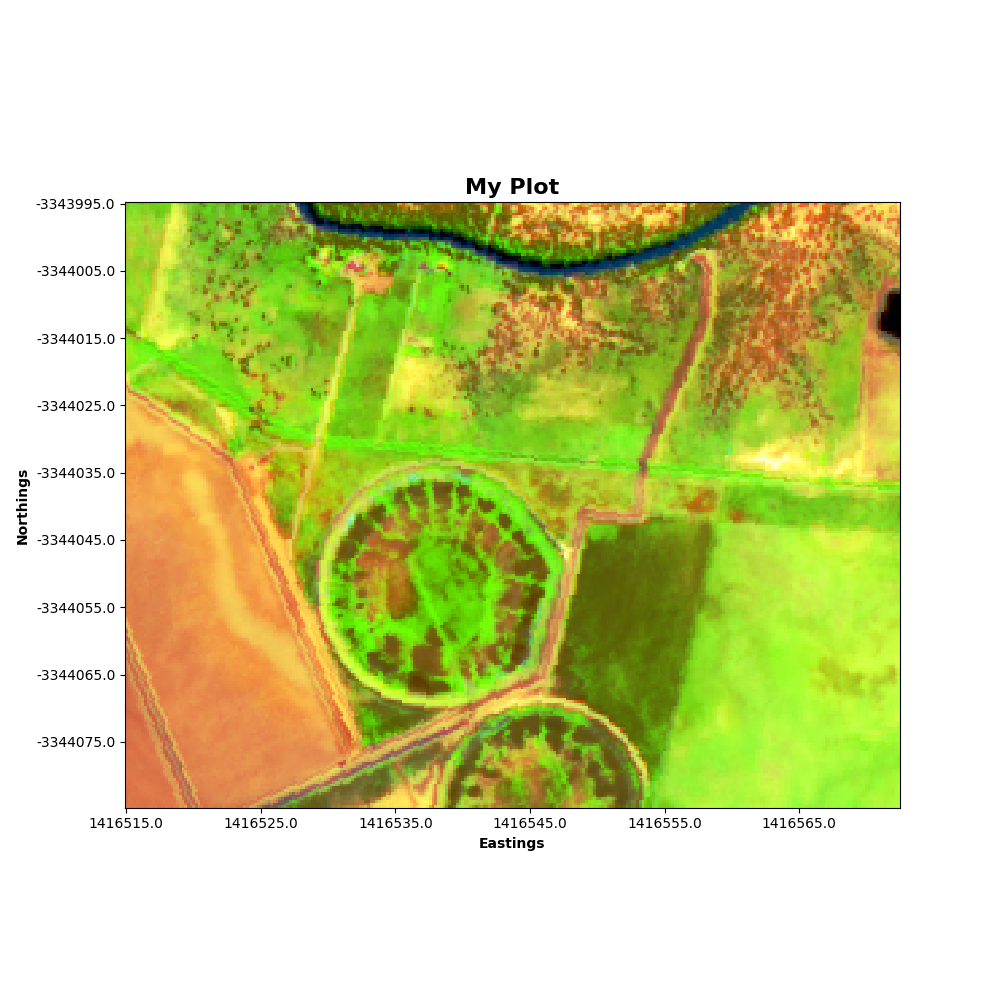

HTML(value='Click on the pixel you would like to interrogate')

In [5]:
DEAPlotting.three_band_image(Sentinel2anofilter, bands = ['swir1', 'nir1', 'green'])
fig = plt.gcf()
w = widgets.HTML("Click on the pixel you would like to interrogate")
def onclick(event):
    global pixelx, pixely
    x, y = int(event.xdata), int(event.ydata)
    image_coords = Sentinel2anofilter.affine * (x, y)
    pixelx = int(image_coords[0])
    pixely = int(image_coords[1])
    w.value = 'pixelx : {}, pixely : {}'.format(pixelx, pixely) 
cid = fig.canvas.mpl_connect('button_press_event', onclick)
display(w)

## Compare Landsat and Sentinel2 for a single pixel

<IPython.core.display.Javascript object>


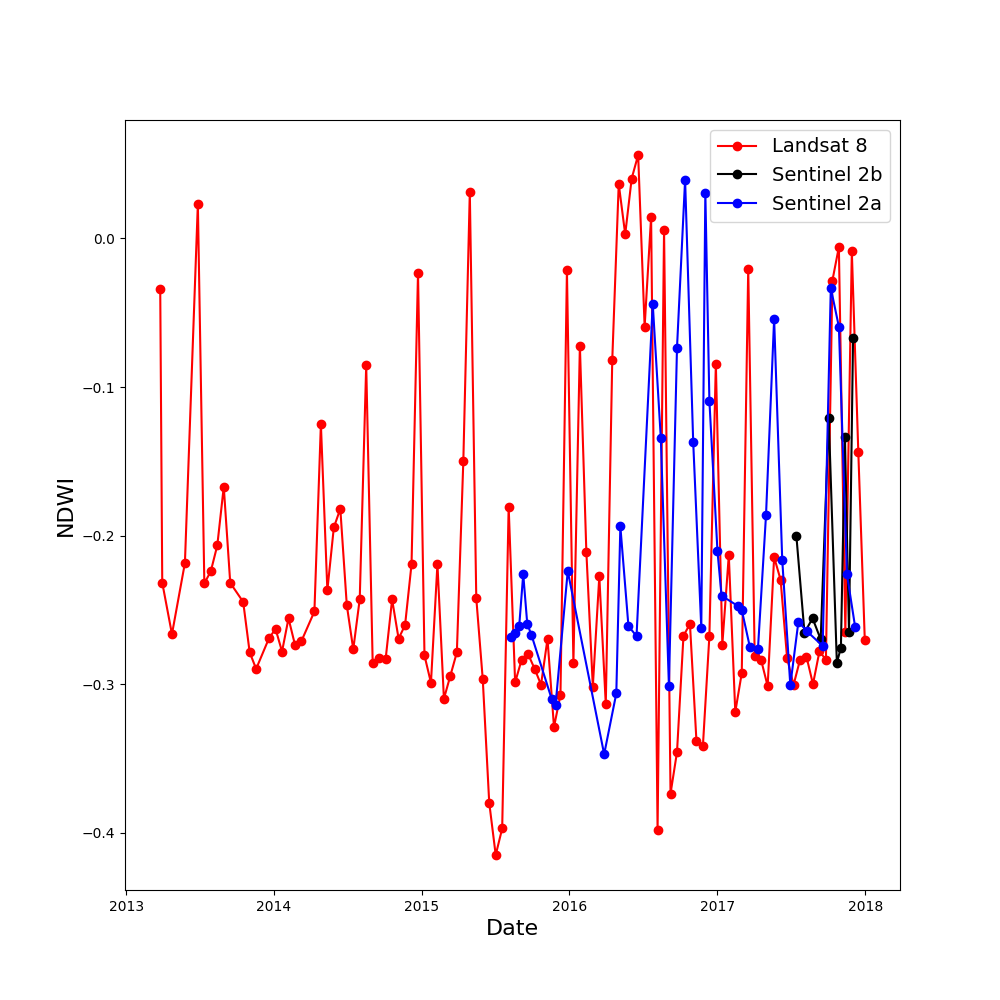

HTML(value='Click on the time you would like to display')

In [19]:
fig = plt.figure(figsize = [10, 10])

plt.plot(Landsatnofilter.time, LandsatNDWI.sel(y = pixely, x = pixelx, method = 'nearest'), 'ro-')
plt.plot(Sentinel2bnofilter.time, Sentinel2bNDWI.sel(y = pixely, x = pixelx, method = 'nearest'), 'ko-')
plt.plot(Sentinel2anofilter.time, Sentinel2aNDWI.sel(y = pixely, x = pixelx, method = 'nearest'), 'bo-')
plt.legend(labels = ['Landsat 8', 'Sentinel 2b', 'Sentinel 2a', ], fontsize = 14)
plt.xlabel('Date', fontsize = 16)
plt.ylabel('NDWI', fontsize = 16)

w = widgets.HTML("Click on the time you would like to display")
def onclick(event):
    global timeOfInterest
    timeOfInterest = event.xdata
    w.value = 'time of interest : {}'.format(timeOfInterest) 
cid = fig.canvas.mpl_connect('button_press_event', onclick)
display(w)

In [13]:
WhichSensor = Sentinel2anofilter

In [22]:
#Date
time_slice = matplotlib.dates.num2date(timeOfInterest).date() #Convert clicked int to datetime format
time_slice=str(time_slice) #Convert clicked value to str
time_slice= pd.to_datetime(time_slice, format='%Y-%m-%d') #Convert clicked value to correct datetime format
time_slice

Timestamp('2016-03-25 00:00:00')

<IPython.core.display.Javascript object>


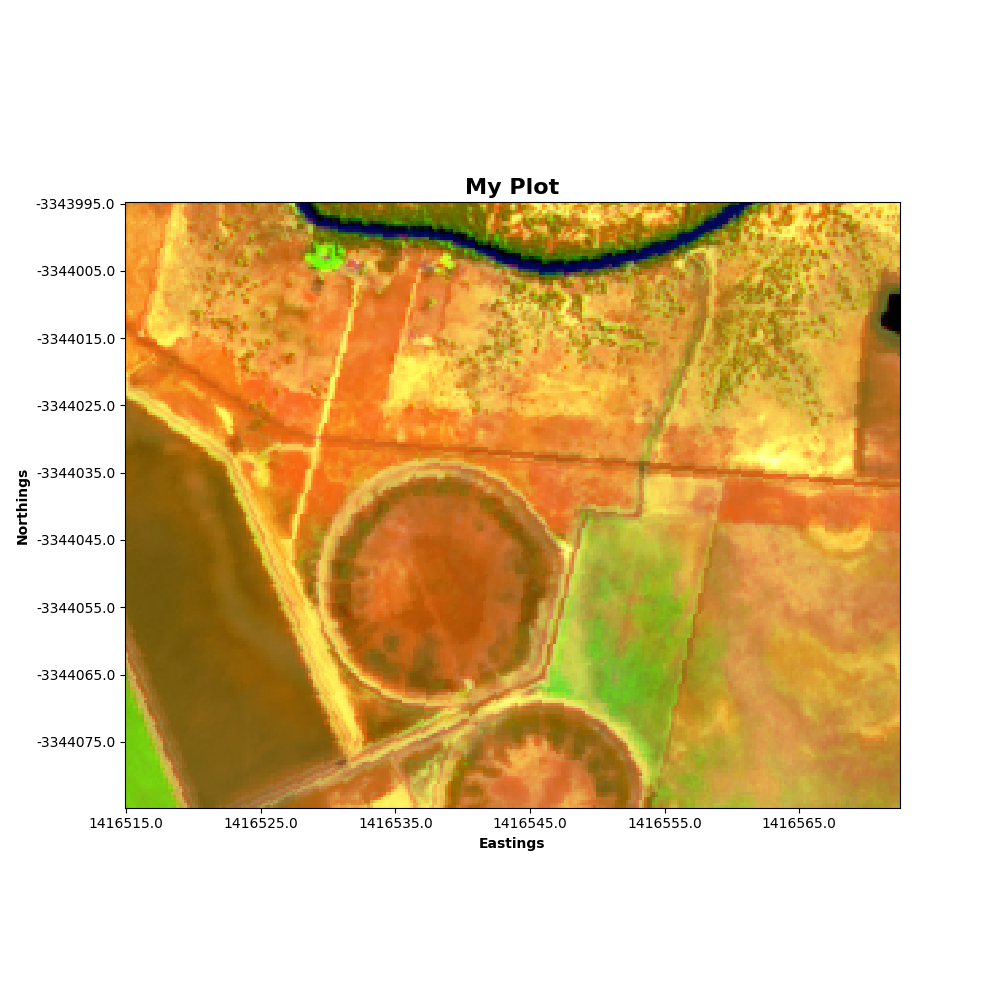

In [23]:
DEAPlotting.three_band_image(WhichSensor.sel(time = time_slice, method = 'nearest'), bands = ['swir1', 'nir1', 'green'])